### Pre-Processing and Feature Extraction

In [12]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import random
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import numpy

In [2]:
# Define paths for each fracture type
root = '../data/'
train_paths = {
    'Hairline Fracture': root + 'Hairline Fracture/Train',
    'Spiral Fracture': root + 'Spiral Fracture/Train',
    'Greenstick Fracture': root + 'Greenstick fracture/Train',
    'Comminuted Fracture': root + 'Comminuted fracture/Train',
    'Fracture Dislocation': root + 'Fracture Dislocation/Train',
    'Pathological Fracture': root + 'Pathological fracture/Train',
    'Longitudinal Fracture': root + 'Longitudinal fracture/Train',
    'Oblique Fracture': root + 'Oblique fracture/Train',
    'Impacted Fracture': root + 'Impacted fracture/Train',
    'Avulsion Fracture': root + 'Avulsion fracture/Train'
}

test_paths = {
    'Hairline Fracture': root + 'Hairline Fracture/Test',
    'Spiral Fracture': root + 'Spiral Fracture/Test',
    'Greenstick Fracture': root + 'Greenstick fracture/Test',
    'Comminuted Fracture': root + 'Comminuted fracture/Test',
    'Fracture Dislocation': root + 'Fracture Dislocation/Test',
    'Pathological Fracture': root + 'Pathological fracture/Test',
    'Longitudinal Fracture': root + 'Longitudinal fracture/Test',
    'Oblique Fracture': root + 'Oblique fracture/Test',
    'Impacted Fracture': root + 'Impacted fracture/Test',
    'Avulsion Fracture': root + 'Avulsion fracture/Test'
}

In [3]:
# Function to load and preprocess an image
def load_image(image_path, image_size=(512, 512), unsharp_amount=1.5, sigma=1.5):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    
    # Decode the JPEG image into a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert to grayscale
    image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2GRAY)
    
    # Resize the image to the desired size
    image = cv2.resize(image, image_size)
    
    # Apply histogram equalization
    # image = cv2.equalizeHist(image)
    
    # Create a Gaussian blurred version of the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    
    # Calculate the unsharp mask
    image = cv2.addWeighted(image, 1 + unsharp_amount, blurred, -unsharp_amount, 0)
    
    return image

def create_2d_gaussian(size, sigma):
    # Create a linear space from -size//2 to size//2
    ax = np.linspace(-(size // 2), size // 2, size)
    # Create a meshgrid from the linear space
    xx, yy = np.meshgrid(ax, ax)
    # Calculate the Gaussian kernel
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    # Normalize the kernel so that the sum is 1
    return kernel / np.sum(kernel)

def convolve2d(image, kernel):
    # Flip the kernel for convolution
    kernel = kernel[::-1, ::-1]
    # Create an output array of the same shape as the input image
    output = np.zeros_like(image)
    # Pad the input image to handle borders
    image_padded = np.pad(image, [(kernel.shape[0]//2, kernel.shape[0]//2), 
                                  (kernel.shape[1]//2, kernel.shape[1]//2)], mode='reflect')
    # Loop over each pixel in the image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # Perform element-wise multiplication and sum the results
            output[y, x] = (kernel * image_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output

def gaussian_and_laplacian_stack(img, levels, size=17, sigma=3):
    # Initialize the Gaussian stack with the original image
    gaussian_stack = [img]
    # Initialize the Laplacian stack
    laplacian_stack = []

    # Loop to create each level of the Gaussian and Laplacian stacks
    for i in range(1, levels):
        # Create the Gaussian kernel
        gaussian_kernel = create_2d_gaussian(size, sigma)
        # Convolve the last image in the Gaussian stack with the Gaussian kernel
        gaussian = convolve2d(gaussian_stack[-1], gaussian_kernel)
        # Append the resulting image to the Gaussian stack
        gaussian_stack.append(gaussian)
        # Calculate the Laplacian image by subtracting the current Gaussian image from the previous one
        laplacian = gaussian_stack[-2] - gaussian
        # Append the Laplacian image to the Laplacian stack
        laplacian_stack.append(laplacian)

    # The last level of the Laplacian stack is the last image in the Gaussian stack
    laplacian_stack.append(gaussian_stack[-1])
    return gaussian_stack, laplacian_stack

def visualize_stack(in_stack, title):
    # Create a figure with subplots for each level in the stack
    fig, axes = plt.subplots(1, len(in_stack), figsize=(15, 10))
    # Loop over each level and corresponding subplot axis
    for i, (ax, img) in enumerate(zip(axes, in_stack)):
        # Display the image on the axis
        ax.imshow(img, cmap='gray', vmin=np.min(img), vmax=np.max(img))
        # Set the title of the subplot to indicate the level
        ax.set_title(f'Level {i+1}')
        # Remove the axis ticks and labels
        ax.axis('off')
    # Set the overall title for the figure
    fig.suptitle(title)
    # Show the figure
    plt.show()

# Custom feature extraction functions
def extract_hog_features(image):
    # Extract HOG features and the HOG image
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    return fd, hog_image

def extract_canny_edges(image):

    # Extract Canny edges
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    return edges.ravel(), edges

def extract_contours(image, max_contours=5):

    # Apply a binary threshold to the grayscale image
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Initialize a list to store contour features
    contour_features = []
    # Loop over the first 5 contours
    for contour in contours[:5]:
        # Calculate the moments of the contour
        moments = cv2.moments(contour)
        # Calculate the Hu moments and flatten them
        hu_moments = cv2.HuMoments(moments).flatten()
        # Append the Hu moments to the contour features list
        contour_features.extend(hu_moments)
        
    # Pad with zeros if fewer than max_contours are found
    while len(contour_features) < max_contours * 7:
        contour_features.append(0.0)
        
    return np.array(contour_features), contours

### SVM Model

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn.decomposition import PCA

from tqdm import tqdm
import time

In [5]:
# Extract features for all images and prepare the dataset
def prepare_dataset(paths):
    features = []
    labels = []
    feature_shapes = []

    for class_name, class_path in paths.items():
        image_files = tf.io.gfile.listdir(class_path)
        for image_file in tqdm(image_files, desc=f"Processing {class_name}"):
            image_path = os.path.join(class_path, image_file)
            image = load_image(image_path)
            hog_features, _ = extract_hog_features(image)
            canny_features, _ = extract_canny_edges(image)
            contour_features, _ = extract_contours(image)
            
            # Store the shapes of the feature vectors
            feature_shapes.append({
                "class": class_name,
                "image_file": image_file,
                "hog_shape": hog_features.shape,
                "canny_shape": canny_features.shape,
                "contour_shape": contour_features.shape
            })
            
            # Ensure that all features are flattened
            hog_features = hog_features.flatten()
            canny_features = canny_features.flatten()
            contour_features = contour_features.flatten()
            
            # Concatenate feature vectors
            feature_vector = np.concatenate((hog_features, canny_features, contour_features))
            features.append(feature_vector)
            labels.append(class_name)
        print(f"{class_name} Completed")
    
    return np.array(features), np.array(labels), feature_shapes

In [6]:
print("Preparing Training Dataset")
X_train, y_train, train_feature_shapes = prepare_dataset(train_paths)

Preparing Training Dataset


Processing Hairline Fracture: 100%|██████████████████████████████████████████████████| 101/101 [00:52<00:00,  1.91it/s]


Hairline Fracture Completed


Processing Spiral Fracture: 100%|██████████████████████████████████████████████████████| 74/74 [00:38<00:00,  1.92it/s]


Spiral Fracture Completed


Processing Greenstick Fracture: 100%|████████████████████████████████████████████████| 106/106 [00:54<00:00,  1.93it/s]


Greenstick Fracture Completed


Processing Comminuted Fracture: 100%|████████████████████████████████████████████████| 134/134 [01:09<00:00,  1.92it/s]


Comminuted Fracture Completed


Processing Fracture Dislocation: 100%|███████████████████████████████████████████████| 137/137 [01:10<00:00,  1.95it/s]


Fracture Dislocation Completed


Processing Pathological Fracture: 100%|██████████████████████████████████████████████| 116/116 [00:59<00:00,  1.96it/s]


Pathological Fracture Completed


Processing Longitudinal Fracture: 100%|████████████████████████████████████████████████| 68/68 [00:34<00:00,  1.97it/s]


Longitudinal Fracture Completed


Processing Oblique Fracture: 100%|█████████████████████████████████████████████████████| 69/69 [00:34<00:00,  1.97it/s]


Oblique Fracture Completed


Processing Impacted Fracture: 100%|████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.97it/s]


Impacted Fracture Completed


Processing Avulsion Fracture: 100%|██████████████████████████████████████████████████| 109/109 [00:55<00:00,  1.97it/s]


Avulsion Fracture Completed


In [7]:
# Prepare the test dataset
print("Preparing Test Dataset")
X_test, y_test, test_feature_shapes = prepare_dataset(test_paths)

Preparing Test Dataset


Processing Hairline Fracture: 100%|████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


Hairline Fracture Completed


Processing Spiral Fracture: 100%|██████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.97it/s]


Spiral Fracture Completed


Processing Greenstick Fracture: 100%|██████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


Greenstick Fracture Completed


Processing Comminuted Fracture: 100%|██████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.98it/s]


Comminuted Fracture Completed


Processing Fracture Dislocation: 100%|█████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.99it/s]


Fracture Dislocation Completed


Processing Pathological Fracture: 100%|████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.99it/s]


Pathological Fracture Completed


Processing Longitudinal Fracture: 100%|████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.99it/s]


Longitudinal Fracture Completed


Processing Oblique Fracture: 100%|█████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


Oblique Fracture Completed


Processing Impacted Fracture: 100%|██████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.98it/s]


Impacted Fracture Completed


Processing Avulsion Fracture: 100%|████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.98it/s]

Avulsion Fracture Completed


In [10]:
# Convert feature_shapes to a DataFrame for better analysis
df_train_feature_shapes = pd.DataFrame(train_feature_shapes)
df_test_feature_shapes = pd.DataFrame(test_feature_shapes)


# Analyze the DataFrame to find inconsistencies
train_hog_shapes = df_train_feature_shapes['hog_shape'].value_counts()
train_canny_shapes = df_train_feature_shapes['canny_shape'].value_counts()
train_contour_shapes = df_train_feature_shapes['contour_shape'].value_counts()

# Analyze the DataFrame to find inconsistencies
test_hog_shapes = df_test_feature_shapes['hog_shape'].value_counts()
test_canny_shapes = df_test_feature_shapes['canny_shape'].value_counts()
test_contour_shapes = df_test_feature_shapes['contour_shape'].value_counts()


# Display the inconsistent shapes
print("HOG Feature Shape Counts:")
print(train_hog_shapes.index[0][0])
print("\nCanny Feature Shape Counts:")
print(train_canny_shapes.index[0][0])
print("\nContour Feature Shape Counts:")
print(train_contour_shapes.index[0][0])

print("\n\n")

# Display the inconsistent shapes
print("HOG Feature Shape Counts:")
print(test_hog_shapes.index[0][0])
print("\nCanny Feature Shape Counts:")
print(test_canny_shapes.index[0][0])
print("\nContour Feature Shape Counts:")
print(test_contour_shapes.index[0][0])

HOG Feature Shape Counts:
142884

Canny Feature Shape Counts:
262144

Contour Feature Shape Counts:
35



HOG Feature Shape Counts:
142884

Canny Feature Shape Counts:
262144

Contour Feature Shape Counts:
35


No PCA

In [13]:
# Normalize the features
print("Normalizing Features")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode labels
print("Encoding labels")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SVM classifier
print("Training SVM")
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train_encoded)

# Make predictions on the training set
print("Predicting Training Set")
y_train_pred = classifier.predict(X_train)

# Make predictions on the test set
print("Predicting Test Set")
y_test_pred = classifier.predict(X_test)

# Evaluate the classifier on the training set
print("Training Set Accuracy:", accuracy_score(y_train_encoded, y_train_pred))
print("Training Set Classification Report:\n", classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Evaluate the classifier on the test set
print("Test Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Normalizing Features
Encoding labels
Training SVM
Predicting Training Set
Predicting Test Set
Training Set Accuracy: 1.0
Training Set Classification Report:
                        precision    recall  f1-score   support

    Avulsion Fracture       1.00      1.00      1.00       109
  Comminuted Fracture       1.00      1.00      1.00       134
 Fracture Dislocation       1.00      1.00      1.00       137
  Greenstick Fracture       1.00      1.00      1.00       106
    Hairline Fracture       1.00      1.00      1.00       101
    Impacted Fracture       1.00      1.00      1.00        75
Longitudinal Fracture       1.00      1.00      1.00        68
     Oblique Fracture       1.00      1.00      1.00        69
Pathological Fracture       1.00      1.00      1.00       116
      Spiral Fracture       1.00      1.00      1.00        74

             accuracy                           1.00       989
            macro avg       1.00      1.00      1.00       989
         weighted avg

PCA with max PCs

In [14]:
# Get the most common shape for each feature type
hog_len = train_hog_shapes.index[0][0]
canny_len = train_canny_shapes.index[0][0]
contour_len = train_contour_shapes.index[0][0]

print("Automatically determined dimensions:")
print("HOG Feature Length:", hog_len)
print("Canny Feature Length:", canny_len)
print("Contour Feature Length:", contour_len)

# Normalize the features
print("Normalizing Features")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the number of samples
n_samples = X_train.shape[0]

# Split the features back into HOG, Canny, and Contour
X_train_hog = X_train[:, :hog_len]
X_train_canny = X_train[:, hog_len:hog_len+canny_len]
X_train_contour = X_train[:, hog_len+canny_len:]

X_test_hog = X_test[:, :hog_len]
X_test_canny = X_test[:, hog_len:hog_len+canny_len]
X_test_contour = X_test[:, hog_len+canny_len:]

# Apply PCA to each feature type separately
print("Applying PCA to HOG Features")
pca_hog = PCA(n_components=min(hog_len, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Applying PCA to Canny Features")
pca_canny = PCA(n_components=min(canny_len, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_canny_pca = pca_canny.fit_transform(X_train_canny)
X_test_canny_pca = pca_canny.transform(X_test_canny)

print("Applying PCA to Contour Features")
pca_contour = PCA(n_components=min(contour_len, n_samples))  # The contour feature length is 35
X_train_contour_pca = pca_contour.fit_transform(X_train_contour)
X_test_contour_pca = pca_contour.transform(X_test_contour)


# Concatenate the reduced features back together
X_train_pca = np.concatenate((X_train_hog_pca, X_train_canny_pca, X_train_contour_pca), axis=1)
X_test_pca = np.concatenate((X_test_hog_pca, X_test_canny_pca, X_test_contour_pca), axis=1)

# Encode labels
print("Encoding labels")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SVM classifier
print("Training SVM")
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the training set
print("Predicting Training Set")
y_train_pred = classifier.predict(X_train_pca)

# Make predictions on the test set
print("Predicting Test Set")
y_test_pred = classifier.predict(X_test_pca)

# Evaluate the classifier on the training set
print("Training Set Accuracy:", accuracy_score(y_train_encoded, y_train_pred))
print("Training Set Classification Report:\n", classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Evaluate the classifier on the test set
print("Test Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Automatically determined dimensions:
HOG Feature Length: 142884
Canny Feature Length: 262144
Contour Feature Length: 35
Normalizing Features
Applying PCA to HOG Features
Applying PCA to Canny Features
Applying PCA to Contour Features
Encoding labels
Training SVM
Predicting Training Set
Predicting Test Set
Training Set Accuracy: 1.0
Training Set Classification Report:
                        precision    recall  f1-score   support

    Avulsion Fracture       1.00      1.00      1.00       109
  Comminuted Fracture       1.00      1.00      1.00       134
 Fracture Dislocation       1.00      1.00      1.00       137
  Greenstick Fracture       1.00      1.00      1.00       106
    Hairline Fracture       1.00      1.00      1.00       101
    Impacted Fracture       1.00      1.00      1.00        75
Longitudinal Fracture       1.00      1.00      1.00        68
     Oblique Fracture       1.00      1.00      1.00        69
Pathological Fracture       1.00      1.00      1.00       11

PCA with half PCs

In [15]:
# Normalize the features
print("Normalizing Features")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the number of samples
n_samples = X_train.shape[0]

# Split the features back into HOG, Canny, and Contour
X_train_hog = X_train[:, :hog_len]
X_train_canny = X_train[:, hog_len:hog_len+canny_len]
X_train_contour = X_train[:, hog_len+canny_len:]

X_test_hog = X_test[:, :hog_len]
X_test_canny = X_test[:, hog_len:hog_len+canny_len]
X_test_contour = X_test[:, hog_len+canny_len:]

# Apply PCA to each feature type separately
print("Applying PCA to HOG Features")
pca_hog = PCA(n_components=min(500, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Applying PCA to Canny Features")
pca_canny = PCA(n_components=min(500, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_canny_pca = pca_canny.fit_transform(X_train_canny)
X_test_canny_pca = pca_canny.transform(X_test_canny)

print("Applying PCA to Contour Features")
pca_contour = PCA(n_components=min(12, n_samples))  # The contour feature length is 35
X_train_contour_pca = pca_contour.fit_transform(X_train_contour)
X_test_contour_pca = pca_contour.transform(X_test_contour)


# Concatenate the reduced features back together
X_train_pca = np.concatenate((X_train_hog_pca, X_train_canny_pca, X_train_contour_pca), axis=1)
X_test_pca = np.concatenate((X_test_hog_pca, X_test_canny_pca, X_test_contour_pca), axis=1)

# Encode labels
print("Encoding labels")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SVM classifier
print("Training SVM")
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the training set
print("Predicting Training Set")
y_train_pred = classifier.predict(X_train_pca)

# Make predictions on the test set
print("Predicting Test Set")
y_test_pred = classifier.predict(X_test_pca)

# Evaluate the classifier on the training set
print("Training Set Accuracy:", accuracy_score(y_train_encoded, y_train_pred))
print("Training Set Classification Report:\n", classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Evaluate the classifier on the test set
print("Test Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Normalizing Features
Applying PCA to HOG Features
Applying PCA to Canny Features
Applying PCA to Contour Features
Encoding labels
Training SVM
Predicting Training Set
Predicting Test Set
Training Set Accuracy: 1.0
Training Set Classification Report:
                        precision    recall  f1-score   support

    Avulsion Fracture       1.00      1.00      1.00       109
  Comminuted Fracture       1.00      1.00      1.00       134
 Fracture Dislocation       1.00      1.00      1.00       137
  Greenstick Fracture       1.00      1.00      1.00       106
    Hairline Fracture       1.00      1.00      1.00       101
    Impacted Fracture       1.00      1.00      1.00        75
Longitudinal Fracture       1.00      1.00      1.00        68
     Oblique Fracture       1.00      1.00      1.00        69
Pathological Fracture       1.00      1.00      1.00       116
      Spiral Fracture       1.00      1.00      1.00        74

             accuracy                           1.00  

PCA with 1/4 PCs

In [16]:
# Normalize the features
print("Normalizing Features")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the number of samples
n_samples = X_train.shape[0]

# Split the features back into HOG, Canny, and Contour
X_train_hog = X_train[:, :hog_len]
X_train_canny = X_train[:, hog_len:hog_len+canny_len]
X_train_contour = X_train[:, hog_len+canny_len:]

X_test_hog = X_test[:, :hog_len]
X_test_canny = X_test[:, hog_len:hog_len+canny_len]
X_test_contour = X_test[:, hog_len+canny_len:]

# Apply PCA to each feature type separately
print("Applying PCA to HOG Features")
pca_hog = PCA(n_components=min(250, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Applying PCA to Canny Features")
pca_canny = PCA(n_components=min(250, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_canny_pca = pca_canny.fit_transform(X_train_canny)
X_test_canny_pca = pca_canny.transform(X_test_canny)

print("Applying PCA to Contour Features")
pca_contour = PCA(n_components=min(12, n_samples))  # The contour feature length is 35
X_train_contour_pca = pca_contour.fit_transform(X_train_contour)
X_test_contour_pca = pca_contour.transform(X_test_contour)


# Concatenate the reduced features back together
X_train_pca = np.concatenate((X_train_hog_pca, X_train_canny_pca, X_train_contour_pca), axis=1)
X_test_pca = np.concatenate((X_test_hog_pca, X_test_canny_pca, X_test_contour_pca), axis=1)

# Encode labels
print("Encoding labels")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SVM classifier
print("Training SVM")
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the training set
print("Predicting Training Set")
y_train_pred = classifier.predict(X_train_pca)

# Make predictions on the test set
print("Predicting Test Set")
y_test_pred = classifier.predict(X_test_pca)

# Evaluate the classifier on the training set
print("Training Set Accuracy:", accuracy_score(y_train_encoded, y_train_pred))
print("Training Set Classification Report:\n", classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Evaluate the classifier on the test set
print("Test Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Normalizing Features
Applying PCA to HOG Features
Applying PCA to Canny Features
Applying PCA to Contour Features
Encoding labels
Training SVM
Predicting Training Set
Predicting Test Set
Training Set Accuracy: 1.0
Training Set Classification Report:
                        precision    recall  f1-score   support

    Avulsion Fracture       1.00      1.00      1.00       109
  Comminuted Fracture       1.00      1.00      1.00       134
 Fracture Dislocation       1.00      1.00      1.00       137
  Greenstick Fracture       1.00      1.00      1.00       106
    Hairline Fracture       1.00      1.00      1.00       101
    Impacted Fracture       1.00      1.00      1.00        75
Longitudinal Fracture       1.00      1.00      1.00        68
     Oblique Fracture       1.00      1.00      1.00        69
Pathological Fracture       1.00      1.00      1.00       116
      Spiral Fracture       1.00      1.00      1.00        74

             accuracy                           1.00  

PCA with 1/8 PCs

In [18]:
# Normalize the features
print("Normalizing Features")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the number of samples
n_samples = X_train.shape[0]

# Split the features back into HOG, Canny, and Contour
X_train_hog = X_train[:, :hog_len]
X_train_canny = X_train[:, hog_len:hog_len+canny_len]
X_train_contour = X_train[:, hog_len+canny_len:]

X_test_hog = X_test[:, :hog_len]
X_test_canny = X_test[:, hog_len:hog_len+canny_len]
X_test_contour = X_test[:, hog_len+canny_len:]

# Apply PCA to each feature type separately
print("Applying PCA to HOG Features")
pca_hog = PCA(n_components=min(50, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Applying PCA to Canny Features")
pca_canny = PCA(n_components=min(50, n_samples))  # Use max_components or the feature length, whichever is smaller
X_train_canny_pca = pca_canny.fit_transform(X_train_canny)
X_test_canny_pca = pca_canny.transform(X_test_canny)

print("Applying PCA to Contour Features")
pca_contour = PCA(n_components=min(12, n_samples))  # The contour feature length is 35
X_train_contour_pca = pca_contour.fit_transform(X_train_contour)
X_test_contour_pca = pca_contour.transform(X_test_contour)


# Concatenate the reduced features back together
X_train_pca = np.concatenate((X_train_hog_pca, X_train_canny_pca, X_train_contour_pca), axis=1)
X_test_pca = np.concatenate((X_test_hog_pca, X_test_canny_pca, X_test_contour_pca), axis=1)

# Encode labels
print("Encoding labels")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SVM classifier
print("Training SVM")
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train_pca, y_train_encoded)

# Make predictions on the training set
print("Predicting Training Set")
y_train_pred = classifier.predict(X_train_pca)

# Make predictions on the test set
print("Predicting Test Set")
y_test_pred = classifier.predict(X_test_pca)

# Evaluate the classifier on the training set
print("Training Set Accuracy:", accuracy_score(y_train_encoded, y_train_pred))
print("Training Set Classification Report:\n", classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Evaluate the classifier on the test set
print("Test Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Normalizing Features
Applying PCA to HOG Features
Applying PCA to Canny Features
Applying PCA to Contour Features
Encoding labels
Training SVM
Predicting Training Set
Predicting Test Set
Training Set Accuracy: 0.9949443882709808
Training Set Classification Report:
                        precision    recall  f1-score   support

    Avulsion Fracture       1.00      1.00      1.00       109
  Comminuted Fracture       0.99      0.99      0.99       134
 Fracture Dislocation       0.99      0.99      0.99       137
  Greenstick Fracture       1.00      1.00      1.00       106
    Hairline Fracture       1.00      1.00      1.00       101
    Impacted Fracture       0.99      1.00      0.99        75
Longitudinal Fracture       1.00      1.00      1.00        68
     Oblique Fracture       1.00      1.00      1.00        69
Pathological Fracture       1.00      0.99      1.00       116
      Spiral Fracture       1.00      1.00      1.00        74

             accuracy                  

### Misc Analysis

In [3]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    """
    Get dimensions of an image.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - tuple: Width and height of the image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    return image.shape[1], image.shape[0]

# Lists to store image dimensions
widths = []
heights = []

# Loop over each class and its images
for class_name, class_path in paths.items():
    # List all image files in the directory
    image_files = tf.io.gfile.listdir(class_path)
    # Loop over each image file
    for image_file in image_files:
        # Get the full path to the image
        image_path = os.path.join(class_path, image_file)
        # Get the dimensions of the image
        width, height = get_image_dimensions(image_path)
        # Append the dimensions to the lists
        widths.append(width)
        heights.append(height)

# Convert lists to numpy arrays for easier analysis
widths = np.array(widths)
heights = np.array(heights)

# Calculate statistics
min_width = np.min(widths)
max_width = np.max(widths)
mean_width = np.mean(widths)
median_width = np.median(widths)

min_height = np.min(heights)
max_height = np.max(heights)
mean_height = np.mean(heights)
median_height = np.median(heights)

# Print statistics
print(f"Width: min={min_width}, max={max_width}, mean={mean_width}, median={median_width}")
print(f"Height: min={min_height}, max={max_height}, mean={mean_height}, median={median_height}")

Width: min=58, max=640, mean=429.5490394337715, median=443.0
Height: min=77, max=640, mean=561.4509605662286, median=640.0


In [9]:
# Print label to fracture mapping
label_to_fracture = {label: fracture for label, fracture in enumerate(paths.keys())}
print("Label to Fracture Mapping:")
for label, fracture in label_to_fracture.items():
    print(f"{label}: {fracture}")

Label to Fracture Mapping:
0: Hairline Fracture
1: Spiral Fracture
2: Greenstick Fracture
3: Comminuted Fracture
4: Fracture Dislocation
5: Pathological Fracture
6: Longitudinal Fracture
7: Oblique Fracture
8: Impacted Fracture
9: Avulsion Fracture


Inconsistent image found in class: Avulsion Fracture
Image file: 12891_2019_2585_Fig5_HTML_png.rf.e7f1f0cb0b6723cde402057336779890.jpg
Image path: data/Avulsion fracture/Train\12891_2019_2585_Fig5_HTML_png.rf.e7f1f0cb0b6723cde402057336779890.jpg
Number of contours found: 1
Contour features shape: (7,)
Contour features: [ 5.12772215e+01  9.07899554e+02  1.22862513e+05  1.40072149e+04
 -5.79421323e+08 -4.21180559e+05 -4.38994824e+07]


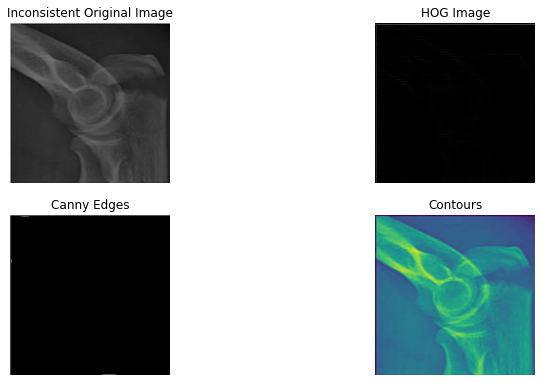

In [20]:
# Found an image that had a contour shape of 7 instead of 35.


import matplotlib.pyplot as plt

# Identify the image with the inconsistent contour feature shape
inconsistent_image_info = df_feature_shapes[df_feature_shapes['contour_shape'] == (7,)]

# Get the details of the inconsistent image
if not inconsistent_image_info.empty:
    inconsistent_class = inconsistent_image_info.iloc[0]['class']
    inconsistent_image_file = inconsistent_image_info.iloc[0]['image_file']
    inconsistent_image_path = os.path.join(paths[inconsistent_class], inconsistent_image_file)

    print(f"Inconsistent image found in class: {inconsistent_class}")
    print(f"Image file: {inconsistent_image_file}")
    print(f"Image path: {inconsistent_image_path}")

    # Load and preprocess the inconsistent image
    inconsistent_image = load_image(inconsistent_image_path)

    # Extract and visualize features for the inconsistent image
    hog_features = extract_hog_features(inconsistent_image)
    canny_features = extract_canny_edges(inconsistent_image)
    contour_features, contours = extract_contours(inconsistent_image)

    # Visualize the inconsistent image and its features
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 2, 1)
    plt.title('Inconsistent Original Image')
    plt.imshow(inconsistent_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 2, 2)
    plt.title('HOG Image')
    _, hog_image = extract_hog_features(inconsistent_image)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 2, 3)
    plt.title('Canny Edges')
    _, canny_image = extract_canny_edges(inconsistent_image)
    plt.imshow(canny_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 2, 4)
    plt.title('Contours')
    plt.imshow(cv2.drawContours(inconsistent_image.copy(), contours, -1, (0, 255, 0), 2))
    plt.axis('off')

    # Analyze the contours to see why the shape is different
    print(f"Number of contours found: {len(contours)}")
    print(f"Contour features shape: {contour_features.shape}")
    print("Contour features:", contour_features)

    plt.show()
else:
    print("No inconsistent image found.")
